# Bayesian Linear Regression

$$
\boldsymbol{\dot{u}} = \boldsymbol{\Theta}\boldsymbol{\xi}
$$

By finding the coefficients $\boldsymbol{\xi}$ that minimize the loss with some optimizing algorithm.

Let us now suppose that the data is affected by noise drawn from a gaussian distribution:

$$
\boldsymbol{\dot{u}} = \boldsymbol{\Theta}\boldsymbol{\xi} + \boldsymbol{\epsilon}
$$

with 

$$
\epsilon_i \sim \mathcal{N}(0,\sigma^2)
$$

$$
<\epsilon_i(t)\epsilon_j(\tau)>=\delta_{i,j}\delta(t-\tau)
$$

This model implies the following likelihood distribution for $\boldsymbol{\dot{u}}$:

$$
P(\boldsymbol{\dot{u}}|\boldsymbol{\Theta},\boldsymbol{\xi},\sigma^2) \propto (\sigma^2)^{-n/2} \exp \left ( -\frac{1}{2\sigma^2} (\boldsymbol{\dot{u}} - \boldsymbol{\Theta}\boldsymbol{\xi} )^T(\boldsymbol{\dot{u}} - \boldsymbol{\Theta}\boldsymbol{\xi} ) \right )
$$

So the minimizing algorithm is basically looking for the coefficients that maximize the likelihood of the observed data (by making $\boldsymbol{\dot{u}} - \boldsymbol{\Theta}\boldsymbol{\xi} $ small).

### Prior distribution

Now, the choice of the proper a priori distribution to estimate the posterior distribution is a crucial matter: it should reflect how the algorithm works, because if, for instance, we impose L2 regularization, the algorithm isn't simply trying to minimize $\boldsymbol{\dot{u}} - \boldsymbol{\Theta}\boldsymbol{\xi}$ (i.e. maximizing the likelihood of the data combined with a uniform prior) but it's also trying to make $||\boldsymbol{\xi}||^2$ small. We can prove that this is the same as imposing a Gaussian prior; first, recall the Maximum A Posteriori (_MAP_) estimation problem:

$$
\hat{\boldsymbol{\xi}}_{MAP} = \argmax_{\boldsymbol{\xi}} P(\boldsymbol{\xi} | \boldsymbol{\Theta},\boldsymbol{\dot{u}},\sigma^2) = \argmax_{\boldsymbol{\xi}}  P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{\Theta},\sigma^2) P(\boldsymbol{\xi})
$$

consider the logarithm:

$$
\log (P(\boldsymbol{\xi} | \boldsymbol{\Theta},\boldsymbol{\dot{u}},\sigma^2)) = \log (P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{\Theta},\sigma^2)) + \log (P(\boldsymbol{\xi}))
$$

We already wrote down the likelihood $P(\boldsymbol{\dot{u}}|\boldsymbol{\xi},\boldsymbol{\Theta},\sigma^2)$ earlier; if we assume a normal multivariate prior $\boldsymbol{\xi}\sim \mathcal{N}(0,\boldsymbol{S})$, we have

$$
\log (P(\boldsymbol{\xi} )) = \log (\mathcal{N}(0,\boldsymbol{S})) = \log \left [ \frac{1}{(2\pi)^{D/2}|\boldsymbol{S}|^{1/2}} \exp (-\frac{1}{2}\boldsymbol{\xi}^T \boldsymbol{S}^{-1}\boldsymbol{\xi}) \right ]
$$

if we also assume $\boldsymbol{S}=\eta \boldsymbol{I}$, we find (ignoring constant terms)

$$
\log (P(\boldsymbol{\xi} )) \propto -\frac{1}{2\eta}||\boldsymbol{\xi}||^2
$$

we can see how a minimizing algorithm that is subject to L2 is also maximizing the posterior distribution for a linear likelihood with a Gaussian prior (we expect the coefficients not to go too far from the origin!)
[...]

## Bayesian Linear Regression

Within the framework of linear regression, a linear relation is assumed to exist between observed data and a number $k$ of explanatory variables: 

$$
y_i = \boldsymbol{X}_i^T \boldsymbol{w} + \epsilon_i 
$$

with

$$
\boldsymbol{X}_i^T = 
\begin{pmatrix}
1 \\
x_1 \\
x_2 \\
\dots \\
x_k 
\end{pmatrix}
$$

and

$$
\boldsymbol{w} = (w_0,w_1,\dots,w_k)
$$

The problem is estimating the model's parameters vector $\boldsymbol{w}$, and more precisely its _probability distribution_, meant as a mathematical formulation of our uncertainty about it, given the observed data $\boldsymbol{X}$, using the Bayes theorem as the cornerstone of our reasoning:

$$
P(model|evidence) = \frac{P(evidence|model)P(model)}{P(evidence)}
$$

What is the likelihood of observing some data given model parameters? Each observation $y_i, \boldsymbol{X}_i$ is drawn from a Gaussian distribution over $y$:

$$
P(evidence|model) = P(y_i|\boldsymbol{X}_i, \boldsymbol{w}) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left [ -\frac{(y_i - \boldsymbol{X}_i^T \boldsymbol{w})^2}{2\sigma^2} \right ]
$$

so multiple observations $\boldsymbol{y},\boldsymbol{X}$ (if independent) have likelihood:

$$
P(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) = \prod_i^N P(y_i|\boldsymbol{X}_i, \boldsymbol{w}) = \frac{1}{(\sigma \sqrt{2\pi})^N} \exp \left [ -  \frac{ \sum_i^N (y_i - \boldsymbol{X}_i^T \boldsymbol{w})^2}{2\sigma^2} \right ]
$$

or, expressed as log-likelihood:

$$
\log[P(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})] = -N \log (\sigma \sqrt{2\pi}) -  \frac{ \sum_i^N (y_i - \boldsymbol{X}_i^T \boldsymbol{w})^2}{2\sigma^2}
$$


In [1]:
from scipy import optimize
from scipy.optimize import minimize, curve_fit

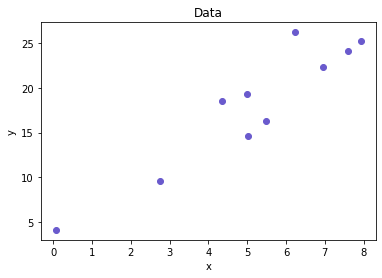

In [2]:
# DATA GENERATION

import numpy as np
import matplotlib.pyplot as plt

N_samples = 10
sigma = 5

X = np.vstack((np.ones(N_samples),np.random.uniform(0,10,N_samples))) # homogeneous coordinates
w = np.array([2.,3.]) # intercept 2, slope 3
                                                                      # X is shaped like (ndim+1,N_samples)

y = X.T @ w + np.random.normal(loc=0,scale=sigma,size=N_samples)

plt.scatter(X[1,:],y,color='slateblue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data")
plt.show()


In [3]:
def log_posterior(w,y,X,sigma):
    """
    Logarithm of the posterior distribution function for coefficients w over a linear Bayesian model.
    
    Arguments
    ------------

    w : float, array-like
    coefficients array (w0,w1,w2,...) of length: N_dim
    y : float, array-like
    observations array (y0,y1,y2,...) of length: N_samples
    X : float, array-like
    features matrix shaped like (N_dim+1,N_samples) with X[0] being an array of ones with length (N_samples)
    (homogeneous coordinates)
    sigma : float, std for gaussian distribution over y

    Returns
    ------------
    posterior : float, posterior evaluated at the point w
    """

    N_samples = len(y)
    

    return -N_samples*np.log(sigma*np.sqrt(2*np.pi)) - np.sum((y-X.T @ w)**2)/(2*sigma**2)

res = 500
w0 = np.linspace(-10,10,res)
w1 = np.linspace(-10,10,res)

w0s,w1s = np.meshgrid(w0,w1)
zz = np.zeros((len(w0),len(w1)))


for i in range(len(w0)):
    for j in range(len(w1)):
        zz[i,j] = log_posterior(np.array([w0[i],w1[j]]),y,X,sigma)


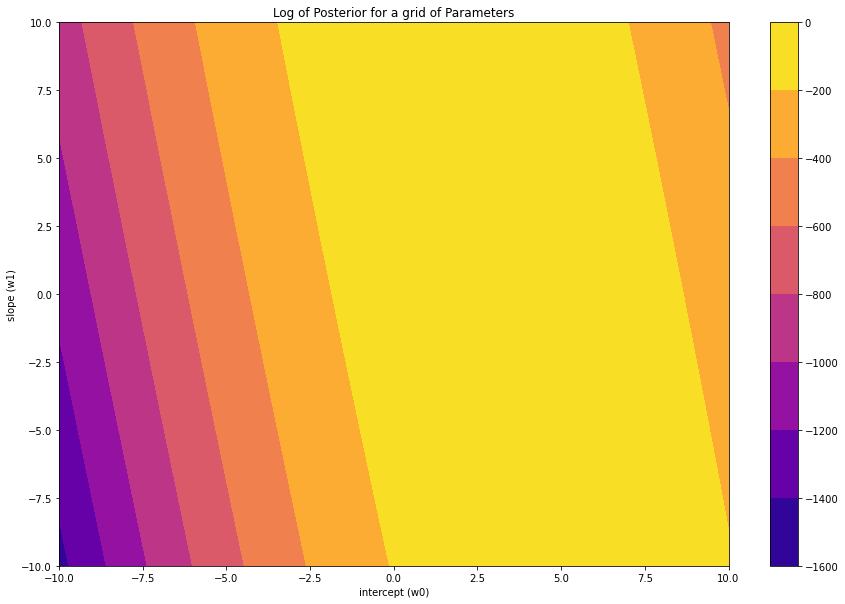

In [4]:
from matplotlib import ticker



fig,ax=plt.subplots(figsize=(15,10))
plt.title("Log of Posterior for a grid of Parameters")
plt.xlabel("intercept (w0)")
plt.ylabel("slope (w1)")
cs=ax.contourf(w0s,w1s,zz,cmap="plasma")
fig.colorbar(cs)

In [5]:
#now we look for the maximum of this function to get the most likely parameters for our model
max_xy = np.where(zz == zz.max() )
most_likely_intercept=w0[int(max_xy[0])]
most_likely_slope=w1[int(max_xy[1])]
print(most_likely_intercept, most_likely_slope)

3.507014028056112 2.825651302605209


10


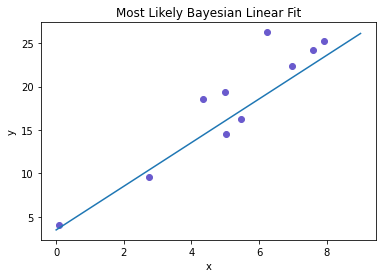

In [7]:
x=np.linspace(0,8,len(X[1,:]))
print(len(X[1,:]))
plt.scatter(X[1,:],y,color='slateblue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Most Likely Bayesian Linear Fit")
f=most_likely_slope*x+most_likely_intercept

f1=x*most_likely_slope + most_likely_intercept
plt.plot(f1)
#bisogna aggiungere sigma alla linea